<a href="https://colab.research.google.com/github/DREAMCHASER04/Machine-Learning/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: Comparison of Regression Models on Predicting Medical Costs

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
![Medical Cost](https://creditkarma-cms.imgix.net/wp-content/uploads/2018/04/boomers-gen-x-high-cost-medical-care.jpg)
In this assignment, you will implement some learning models in the context of a **regression** problem in the [Medical Cost Personal Dataset on Kaggle](https://www.kaggle.com/mirichoi0218/insurance). Specifically, you will attempt to predict the medical cost billed by health insurance using other provided patient's data. For references, you may refer to [my slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit#slide=id.p) or the Google Colab if you need additional sample codes to help with your assignment. To get started, you will need to upload/copy the dataset (.csv) into the same folder as this file.

For deliverables, you must write code in Colab and submit the downloaded Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.


***
##  Task 1: SEE THE BIG PICTURE
Write a paragraph explaining the context of the problem in which you are trying to investigate. We will assume that the data file is put into the same workspace on Colab. Then, you can write some code to load the CSV file and take a quick look at the dataset, and output the following:

 * How big is your dataset? (in terms of MB)
 * How many entries does it have?
 * How many features does it have?
 * Does it contain any categorical data?
 * Is there any missing value?
 * What are some basic statistics you can learn right away about this dataset?

The dataset we have is 0.057MB, It has 1388 entries and 7 features. It indeed contain three categorical data, which are sex, smoker, and region. There are basically no missing values. The basic statistics I can learn from this data set is that there might be some correlations between some features and charges, but there are also some of the non-related.



In [ ]:
# Import some common packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series
from numpy.random import randn

# to make this notebook's output stable across runs
np.random.seed(42)
# Your code goes here for this section, make sure you also include the output to answer the above questions.
data = pd.read_csv('/content/insurance.csv')
print(data.shape)
print(data.head())



(1338, 7)
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


---
##  Task 2: DATA DISCOVERY, CLEANING, AND SCALING

**Data Discover:** Plot out all correlations among the features. You should notice some features are more correlated with your predicted value than other. This information will help you confirm that weights of your regression model later on.

**Data Cleaning:** If your dataset has some missing values, make sure you are able to fill those values with the Imputer class. If your dataset has categorical features, make sure you conver those features into numerical using OneHotEncoder class.

**Feature Scaling** More importantly, your task is to write some codes to normalize the value of each features as follow:

* Subtract the mean value of each feature from the dataset
* Scale (divide) the feature values by their respective standard deviation

**Implementation Note:** You will need to integrate the above operations into a Pipeline to process and transform the training data, then use the same pipeline to transform any validation and testing data.

               age       bmi  children   charges
age       1.000000  0.109272  0.042469  0.299008
bmi       0.109272  1.000000  0.012759  0.198341
children  0.042469  0.012759  1.000000  0.067998
charges   0.299008  0.198341  0.067998  1.000000
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f700463ea50>


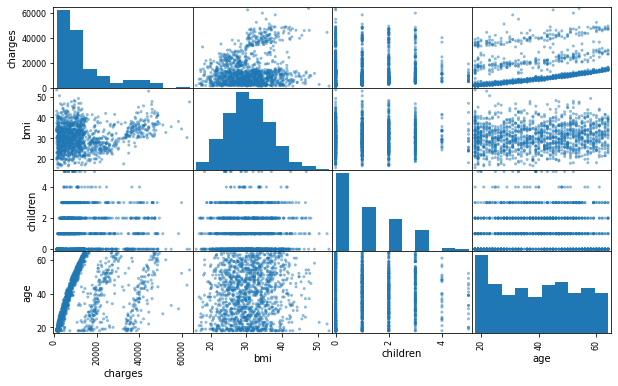

In [ ]:
# You might want to use the following package
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Your code goes here for this section.

corr_matrix = data.corr()
print(corr_matrix)
scatter_matrix = scatter_matrix(data[['charges','bmi','children','age']], figsize=(10,6))
print(scatter_matrix)

In [ ]:
train, test_set = train_test_split(data, test_size=0.1)

X_train_1 = train.drop('charges',axis=1);
y_train_1 = train['charges'].copy();
X_test_1 = test_set.drop('charges',axis=1)
y_test_1 = test_set['charges'].copy();

cat = X_train_1[['sex','smoker','region']]
imputer = SimpleImputer(strategy="median")
X_train_drop = X_train_1.drop(['sex','smoker','region'], axis = 1)
imputer.fit(X_train_drop)

cat_encoder = OneHotEncoder(sparse=False)
d_cat_1hot = cat_encoder.fit_transform(cat)

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
data_num_tr = num_pipeline.fit_transform(X_train_drop)
num_attribs = list(X_train_drop)
cat_attribs = ['sex','smoker','region']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_attribs),
    ])
data_prepared = full_pipeline.fit_transform(X_train_1)

X_train = data_prepared
y_train = y_train_1
X_test = full_pipeline.transform(X_test_1)
y_test = y_test_1

- - -
## Task 3. IMPLEMENT GRADIENT DESCENT
The gradient descent formulation remain the same as one in the lecture. Keep in mind that you will need to add a column $\textbf{x}_0$ with all 1s as part of the training data. You should write code to implement the **MyLinearRegression** class and its predefined methods.

**Gradient Descent:** Notes that you may NOT call the library linear regression which defeats the purpose of this assignment. Make sure your code is well-vectorized.

In [ ]:
# NOTE: You may not use the library Linear Regression, but implement your own!
# REMEMBER to place self.attribute = [] with value from your implementation

class MyLinearRegression:
  """
  Define what a linear regressor can do
  """

  def __init__ (self):
    """
    Initialize the regressor
    """
    self.theta = np.random.randn(12); # parameter vector;
    self.alpha = 0.1; # learning rate
    self.cost  = []; # cost function

  def gradientDescent(self, X_train, y_train, theta, alpha, iters):
    """
    Implementatation of the gradient descent
    INPUT:
    alpha: the learning rate
    iters: number of iterations


    OUTPUT:
    theta: updated value for theta
    cost: value of the cost function
    """
    # implementation code here
    m = len(X_train)
    for iteration in range(iters):
        gradients = 2/m * X_train.T.dot(X_train.dot(self.theta) - y_train)
        cost = np.mean((X_train.dot(self.theta)-y_train)**2)
        self.cost.append(cost)
        self.theta = self.theta - alpha * gradients
    return theta, cost

  def fitUsingGradientDescent(self, X_train, y_train, alpha):
    """
    Train the regressor using gradient descent
    """
    # implementation code here
    X_train = np.c_[np.ones((len(X_train), 1)), X_train]

    return self.gradientDescent(X_train, y_train, self.theta, alpha, 1000)


  def fitUsingNormalEquation(self, X_train, y_train):
    """
    Training using the Normal (close form) equation
    """
    # implementation code here for Task 4.
    X_train_a = np.c_[np.ones((len(X_train), 1)), X_train]  # add x0 = 1 to each instance
    self.theta = np.linalg.pinv(X_train_a.T.dot(X_train_a)).dot(X_train_a.T).dot(y_train)

  def predict(self, X_test):
    """
    Predicting the label
    """
    # implementation code here

    X_test = np.c_[np.ones((len(X_test),1)),X_test]
    y_predict= X_test.dot(self.theta)

    return y_predict


  def __str__(self):
    """
    Print out the parameter out when call print()
    """
    # implement here to return("Parameter vector is %f" % self.theta)   }
    for t in self.theta:
      print(t)

# Your code goes here to call the instance of class MyLinearRegression
myGradientDescentModel = MyLinearRegression()
myGradientDescentModel.fitUsingGradientDescent(X_train, y_train, 0.1)


(array([ 0.23538826, -1.32579377, -0.65900676, -1.66447674,  0.92001146,
        -0.30136312, -0.01591785,  0.91601032, -0.72226888, -0.31198701,
        -1.056328  , -1.05850372]), 37229219.82978537)

* **Learning Rate:** You will try out different learning rates for the dataset and find a learning rate that converges quickly. If you pick a learning rate, your plot of Cost Function $J(\theta)$ against number of iteration will quickly decay to a small value. This also indicates that your implementation is correct. If your learning rate is too large, the cost function $J(\theta)$ can diverge and blow up. From the below plot, you must be able to report the best learning rate the you found to earn credit for this section.

Text(0.5, 1.0, 'Error vs. Training Iterations')

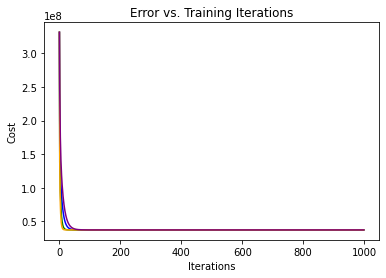

In [ ]:
# Use the following code to plot out your learning rate
# iters and cost must be supplied to plot out the cost function
# You must plot multiple curves corresponding to different learning rates to justify the best one.
Learnrate = []
Model_1 = MyLinearRegression()
Model_2 = MyLinearRegression()
Model_3 = MyLinearRegression()
Model_4 = MyLinearRegression()
Learnrate.append(Model_1)
Learnrate.append(Model_2)
Learnrate.append(Model_3)
Learnrate.append(Model_4)


a = 0.1
for i in range(4):
 Learnrate[i].fitUsingGradientDescent(X_train,y_train,a)
 a += 0.1


plt.plot(list(range(1000)),Learnrate[0].cost,'Blue')
plt.plot(list(range(1000)),Learnrate[1].cost,'Green')
plt.plot(list(range(1000)),Learnrate[2].cost,'Orange')
plt.plot(list(range(1000)),Learnrate[3].cost,'Purple')


plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Error vs. Training Iterations')

- - -
## Task 4. IMPLEMENT THE NORMAL EQUATION

In my lecture, you learn that the closed form solution of linear regression using the normal equation formulation. Using the formula does not require any feature scaling, and should be straight forward to implement:

$
    \mathbf{\theta} = ({\mathbf{X}^{T}\mathbf{X}})^{-1}\mathbf{X}^{T}\mathbf{y}.
$

Note that you still need to add a column of 1's to the $\mathbf{
X}$ matrix to have an intercept term.

In [ ]:
# Implement the normalEquation method of the MyLinearRegression Class before execute the code below:
myNormalEquationModel = MyLinearRegression()
myNormalEquationModel.fitUsingNormalEquation(X_train, y_train)

- - -
## Task 5. COMPARE DIFFERENT IMPLEMENTATIONS

You should be able to evaluate and compare your gradient descent as well as normal equation implementation of linear regression. In theory, they should be the same, or at least similar. For good measures, you must use the built-in library **Scholastic Gradient Descent (SGD)** as a third model for comparison. For each model, you must compute the RMSE on the **test set** as performance measure. The good news is that you can call library functions to compute these as shown below instead of writing your own code:

* Which one yields the best performance measure for your dataset?
* What is your assessment of the error? Good? Okay? Terrible?

In [ ]:
from sklearn.metrics import mean_squared_error

# Use the built-in SGD Regressor model
from sklearn.linear_model import SGDRegressor
mySGDModel = SGDRegressor()
mySGDModel.fit(data_prepared,y_train)
y_predict = mySGDModel.predict(X_test)
mse = mean_squared_error(y_test, y_predict)
mySGDModel_rmse = np.sqrt(mse)
print("SGD_RMSE:", mySGDModel_rmse)

# myGradientDescentModel_rmse
GDM = MyLinearRegression()
GDM.fitUsingGradientDescent(X_train,y_train, 0.1)
y_predict = GDM.predict(X_test)
mse_1 = mean_squared_error(y_test, y_predict)
LinNorre = np.sqrt(mse_1)
print(LinNorre)

# myNormalEquationModel_rmse
GDM = MyLinearRegression()
GDM.fitUsingNormalEquation(X_train,y_train)
y_predict = GDM.predict(X_test)
mse_2 = mean_squared_error(y_test, y_predict)
LinNorr = np.sqrt(mse_2)
print(LinNorr)


SGD_RMSE: 5505.657380003089
5498.560018293017
5498.560018293016


- - -
## Task 6. PRESENT YOUR SOLUTION

Now that you need to write a short memo of one paragraph to be read by a non-technical audience (ie. your manager/boss). Focus on answering the following:

* How can you pitch your solution to this project?
* What did you learn so far about the problem?
* Is there any insight moving forward to improve the solution.

I can pitch my solution here that firstly, the solution should be that there are plenty of model to predict the medical charges. Factors like number of children, ages, bmi, are taken into consideration. And the Machine Learning Model now can actually quite precisely predict the result.
I think I learned that firstly, the different models kind of have similar accuracy in predict the medical charges, and also, the learning rate is quite good.
I think we can include more factors in order to better predict the relationship between the charges, since there might be some other factors.

- - -
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my [slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit?usp=sharing) and/or the textbook
 * Talk to the TA, they are available and there to help you during [office hour](http://bit.ly/cs4774oh)
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 1:...".

Best of luck and have fun!